In [1]:
import kagglehub
import warnings
from flask import Flask, jsonify, request
from pyngrok import ngrok
from werkzeug.utils import secure_filename
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve, auc
import xgboost as xgb
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
warnings.filterwarnings('ignore')

c:\Programming\Python\jaundice\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kagglehub.dataset_download("aiolapo/jaundice-image-data")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\number one\.cache\kagglehub\datasets\aiolapo\jaundice-image-data\versions\1


In [ ]:
def load_images(jaundice_dir, normal_dir):
    images = []
    labels = []

    directories = [(jaundice_dir, 'Jaundice'), (normal_dir, 'Normal')]

    index = 0
    while index < len(directories):
        dir_path, label = directories[index]
        filenames = os.listdir(dir_path)

        if not filenames:
            print(f"No files found in directory: {dir_path}")

        file_index = 0
        while file_index < len(filenames):
            filename = filenames[file_index]
            img_path = os.path.join(dir_path, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if image is not None:
                image = cv2.resize(image, (64, 64)) 
                images.append(image)
                labels.append(label)
            else:
                print(f"Failed to read image: {img_path}")

            file_index += 1

        index += 1

    if not images:
        print("No images were loaded.")

    images = np.array(images)
    labels = np.array(labels)

    print(f"Loaded {len(images)} images with labels.")

    return images, labels


jaundice_dir = 'data/jaundice'
normal_dir = 'data/normal'

images, labels = load_images(jaundice_dir, normal_dir)

if len(images) > 0:
    n_samples = images.shape[0]
    images_flattened = images.reshape(n_samples, -1)
    print(f"Images flattened to shape: {images_flattened.shape}")
else:
    print("No images to flatten.")

Loaded 760 images with labels.
Images flattened to shape: (760, 4096)


In [ ]:
def encode_labels(labels):
    return np.where(labels == 'Jaundice', 1, 0)

encoded_labels = encode_labels(labels)

X_train, X_test, y_train, y_test = train_test_split(images_flattened, encoded_labels, test_size=0.2, random_state=42)

xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xgboost_model.fit(X_train, y_train)

y_pred = xgboost_model.predict(X_test)
y_prob = xgboost_model.predict_proba(X_test)[:, 1]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.79      0.93      0.85       115
    Jaundice       0.50      0.22      0.30        37

    accuracy                           0.76       152
   macro avg       0.64      0.57      0.58       152
weighted avg       0.72      0.76      0.72       152



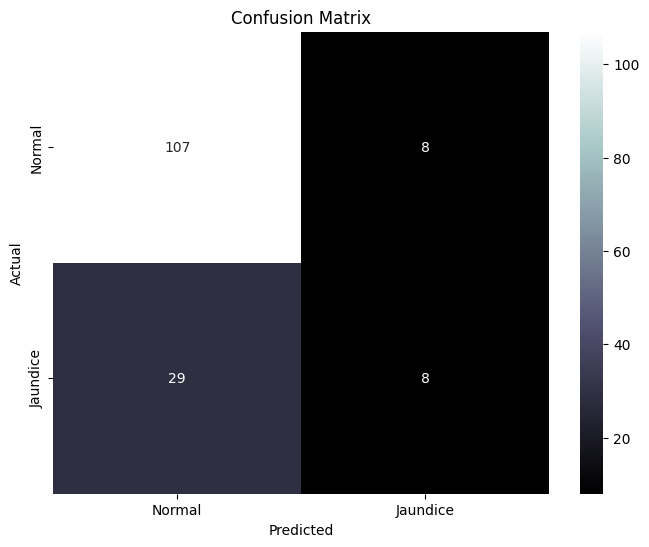

Top features:
      Feature  Importance
3137     3137    0.019460
3159     3159    0.016917
2788     2788    0.016041
962       962    0.015495
1329     1329    0.014874
2325     2325    0.014423
3919     3919    0.013603
3270     3270    0.013149
455       455    0.013113
123       123    0.012786


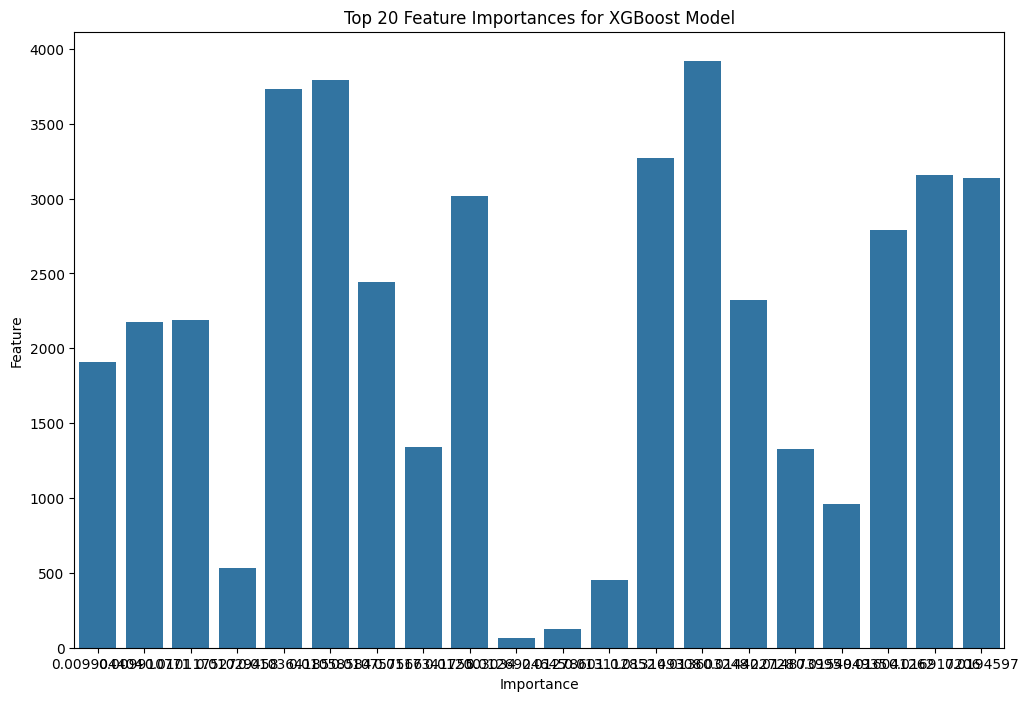

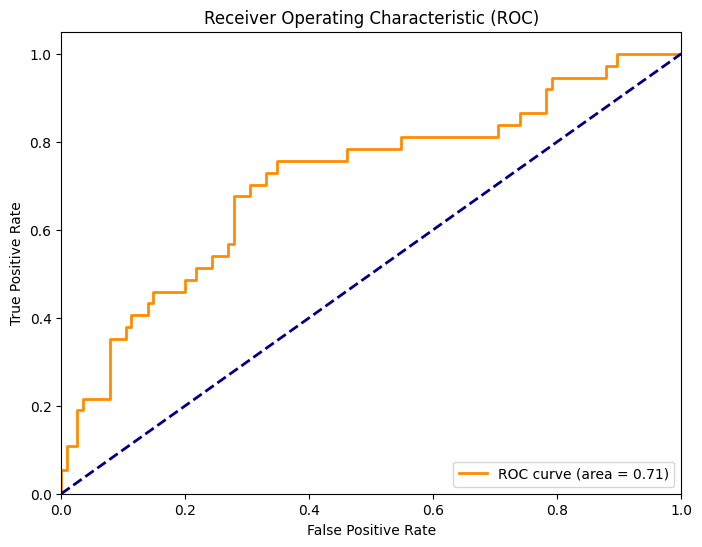

In [10]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Jaundice']))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='bone', xticklabels=['Normal', 'Jaundice'], yticklabels=['Normal', 'Jaundice'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

importances = xgboost_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': np.arange(images_flattened.shape[1]),
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Top features:")
print(feature_importance_df.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances for XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [11]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')
    img = img.resize((64, 64))
    img_array = np.array(img)
    img_array = img_array.flatten()
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [12]:
app = Flask(__name__)
@app.route('/health', methods=['GET'])
def health_check():
    return jsonify({'status': 'healthy'}), 200

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file part in the request'}), 400

    file = request.files['file']

    if file.filename == '':
        return jsonify({'error': 'No selected file'}), 400

    if file:
        filename = secure_filename(file.filename)
        temp_filepath = os.path.join('/tmp', filename)
        file.save(temp_filepath)

        try:
            preprocessed_img = preprocess_image(temp_filepath)

            prediction = xgboost_model.predict(preprocessed_img)

            # Access the prediction result correctly
            print(prediction.flatten()[0])
            predicted_class = 'jaundice' if prediction.flatten()[0] == 1 else 'normal'


            return jsonify({'prediction': predicted_class})

        except Exception as e:
            return jsonify({'error': str(e)}), 500
        finally:
            # Remove the temporary file
            if os.path.exists(temp_filepath):
                os.remove(temp_filepath)
    else:
        return jsonify({'error': 'Something went wrong with the file upload'}), 500

In [13]:
# # prompt: predict this image: "/kaggle/input/jaundice-image-data/jaundice/jaundice (104).jpg"

# image_to_predict_path = "/kaggle/input/jaundice-image-data/normal/normal (1077).jpg"
# preprocessed_single_image = preprocess_image(image_to_predict_path)
# prediction_single_image = xgboost_model.predict(preprocessed_single_image)
# print("sdfklajsdf;dsjkf: "+ str(prediction_single_image))
# predicted_class_single_image = 'jaundice' if prediction_single_image.flatten()[0] == 1 else 'normal'
# print(f"The predicted class for the image is: {predicted_class_single_image}")

In [15]:
port = 5000
public_url = ngrok.connect(port).public_url
os.environ["NGROK_URL"] = public_url
print(' * ngrok tunnel "{}" -> "http://127.0.0.1:{}"'.format(public_url, port))
app.run(host='0.0.0.0', port=port)

KeyboardInterrupt: 